
Prédiction du prix d'une action avec un modèle LSTM (PyTorch)

Dans ce notebook, nous allons :

1. Prétraiter des données boursières.
2. Préparer des séquences temporelles pour entraîner un LSTM.
3. Construire et entraîner un modèle LSTM avec PyTorch.
4. Évaluer la performance du modèle avec le score R².
5. Sauvegarder le modèle et le scaler pour des prédictions futures.


In [1]:

pip install torch torchvision scikit-learn matplotlib pandas seaborn joblib


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 10.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


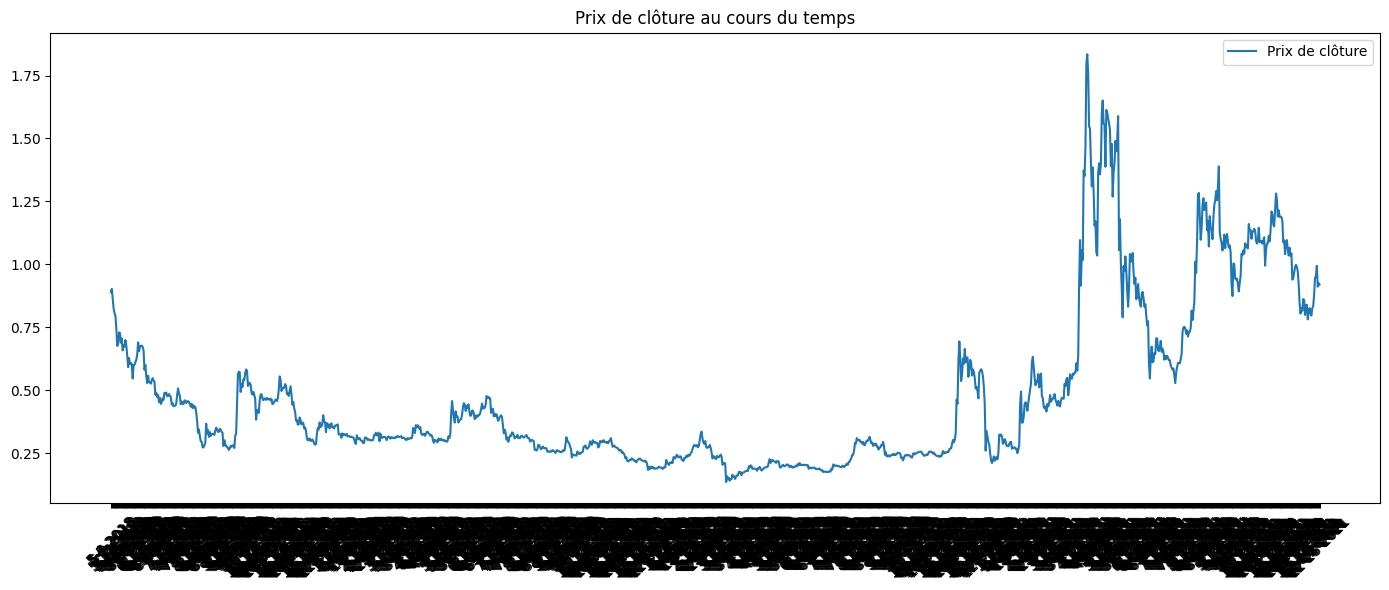

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("stock_market_dataset.csv")
df = df.sort_values('unix')
df['target'] = df['close'].shift(-1)
df = df.dropna()

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['close'], label='Prix de clôture')
plt.title("Prix de clôture au cours du temps")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['close']])

SEQ_LEN = 60
def create_sequences(data, target, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i + seq_len])
        y.append(target[i + seq_len])
    return np.array(x), np.array(y)

X, y = create_sequences(scaled_data, df['target'].values, SEQ_LEN)

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Forme de X_train : {X_train.shape}")


Forme de X_train : (891, 60, 1)


In [4]:

import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=32)


In [6]:

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1])
        return out.squeeze()

model = LSTMModel()


In [7]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader):.4f}")

train(model, train_loader, val_loader, epochs=20)


Epoch 1, Loss: 0.0379
Epoch 2, Loss: 0.0100
Epoch 3, Loss: 0.0089
Epoch 4, Loss: 0.0082
Epoch 5, Loss: 0.0060
Epoch 6, Loss: 0.0035
Epoch 7, Loss: 0.0028
Epoch 8, Loss: 0.0024
Epoch 9, Loss: 0.0024
Epoch 10, Loss: 0.0023
Epoch 11, Loss: 0.0021
Epoch 12, Loss: 0.0019
Epoch 13, Loss: 0.0018
Epoch 14, Loss: 0.0019
Epoch 15, Loss: 0.0017
Epoch 16, Loss: 0.0016
Epoch 17, Loss: 0.0015
Epoch 18, Loss: 0.0015
Epoch 19, Loss: 0.0014
Epoch 20, Loss: 0.0015


In [8]:

from sklearn.metrics import r2_score

model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.numpy())

r2 = r2_score(y_true, y_pred)
print(f"Score R² sur les données de test : {r2:.4f}")


Score R² sur les données de test : 0.6901


In [9]:

import joblib
torch.save(model.state_dict(), "lstm_model.pth")
joblib.dump(scaler, "scaler.save")


['scaler.save']

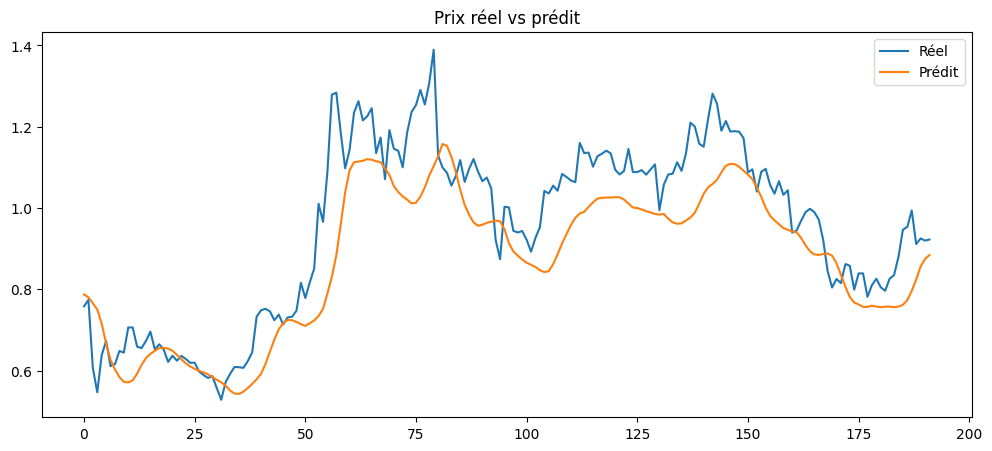

In [10]:

plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Réel')
plt.plot(y_pred, label='Prédit')
plt.title("Prix réel vs prédit")
plt.legend()
plt.show()
